# Quadrotor Ball Sim
by Sebastian Lopez-Cot

This python notebook can be used to run the quad-ball system. The quadrotor will try to send a ball to a desired location given initial conditions and will attempt to return to its original starting point.

fall_time 2.01927510938
Number of decision vars:  320
Solve:  SolutionResult.kSolutionFound
input_traj (40, 2)
time_array (41,)
steps 60000
CONTACT
[  0.      -19.63962]
tang_comp [ 0.  0.]
norm_comp [  0.      -19.63962]
[ -1.22796114e-05   1.49861273e+01]


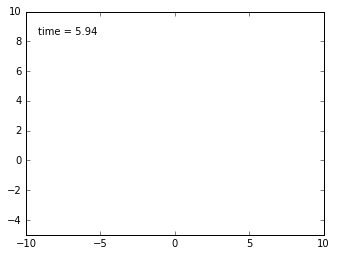

In [35]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

from sim import ProjectileMath, ContactingSwitch, Quadrotor, Ball, Animator
from quad_direct_transcription import QuadDirectTranscription

quad = Quadrotor()
ball = Ball()
sw = ContactingSwitch()
qdt = QuadDirectTranscription(quad.m, quad.g)

dt = 0.0001
steps = 60000
downsample = 600

time = dt * np.arange(steps)

quad_state = np.zeros((steps, 6))
quad_state[0,0] = np.random.choice(np.linspace(-5, 5, 20))
quad_state[0,1] = np.random.choice(np.linspace(0, 5, 20))
quad_state[0,2] = np.random.choice(np.linspace(-np.pi/3.0, np.pi/3.0, 20))

ball_state = np.zeros((steps, 4))
ball_state[0, 0] = 0.0 #4.0
ball_state[0, 1] = 20.0 #-1.0
ball_state[0, 2] = 0.0 #-2.0
ball_state[0, 3] = 0.0 #15.0

lastErr_x = 0.0
lastErr_y = 0.0
lastErr_th = 0.0
limit = 0.45
collision_thresh = 0.05

desired_angle = 0.0

# input_u = np.array([2.2, 0.0])

width = 0.4

# Perform an initial trajectory optimization
quad_goal = np.zeros(6)
quad_goal[0] = 0.0
quad_goal[1] = 0.0
quad_goal[4] = 4.0

fall_time = ProjectileMath.get_drop_time(ball_state[0,:])
print "fall_time", fall_time
quad_traj, input_traj, time_array = qdt.solve(quad_state[0,:], quad_goal, fall_time)
input_u = np.repeat(input_traj, steps/input_traj.shape[0], axis=0)
print "input_traj", input_traj.shape
print "time_array", time_array.shape
print "steps", steps

#interp_traj = np.interp(np.arange(0,steps*dt,dt), time_array, input_u)
#print "interp_traj", interp_traj.shape

interp_traj = np.zeros((steps, 2))
interp_quad = np.zeros((steps, 6))
switch_ind = np.inf
interps = []
interps_2 = []
for j in range(input_u.shape[1]):
    interps.append(scipy.interpolate.interp1d(time_array[:-1], input_traj[:,j]))
    
for j in range(interp_quad.shape[1]):
    interps_2.append(scipy.interpolate.interp1d(time_array[:-1], quad_traj[:,j]))

for i in range(0,steps):
    for j in range(input_u.shape[1]):
        try:
            interp_traj[i,j] = interps[j](i*dt)
        except:
            switch_ind = min(switch_ind, i)
            interp_traj[i,j] = 0.0
            
for i in range(0,steps):
    for j in range(interp_quad.shape[1]):
        try:
            interp_quad[i,j] = interps_2[j](i*dt)
        except:
            interp_quad[i,j] = 0.0
    
for i in range(0,steps-1):
    # Check for contact
    contact = False
    contact_dir = np.array([-np.sin(ball_state[i,2]), np.cos(ball_state[i,2])])
    pos_diff = ball_state[i,0:2] - quad_state[i,0:2]
    tang = np.array([[0.0, 1.0], [-1.0, 0.0]]).dot(contact_dir)
    tang_comp = tang * pos_diff.dot(tang) if abs(np.linalg.norm(pos_diff)) > 1e-6 else np.zeros(2)
    norm_comp = contact_dir * pos_diff.dot(contact_dir) if abs(np.linalg.norm(pos_diff)) > 1e-6 else np.zeros(2)
    if np.linalg.norm(norm_comp) < collision_thresh and np.linalg.norm(tang_comp) <= width / 2.0:
        contact = True

    #contact = (np.linalg.norm(ball_state[i,0:2] - quad_state[i,0:2]) < collision_thresh)


    contact = sw.leads_to_contact(contact)
    if contact:
        print "CONTACT"

    # PD Control
    # error_x = quad_state[i,0] - (ball_state[i-1,0] if i > 0 else 0.0)                                              
    # dE_x = (error_x - lastErr_x) / dt                                             
    # limit = min(0.45 * abs(error_x)/5.0, 0.25)                                    
    # desired_angle = max(min(10000.0*error_x+ 10000.0*dE_x, limit), -limit)        
    # error_y = 0.0 - quad_state[i,1]                                               
    # error_th = desired_angle - quad_state[i,2]                                    
    # dE_y = (error_y - lastErr_y) / dt                                             
    # dE_th = (error_th - lastErr_th) / dt                                          
    # force_command = 0.1*error_y + 0.3*dE_y + 0.981                                
    # roll_command = 4.0*error_th + 1.5*dE_th                                       
    # input_u = np.array([force_command, roll_command])                             
    # lastErr_y = error_y                                                           
    # lastErr_th = error_th
    # lastErr_x = error_x

    # State update
    if i < switch_ind:
        quad_state[i+1,:] = interp_quad[i,:] 
    else:
        quad_state[i+1,:] = quad.step_dynamics(dt, quad_state[i,:], interp_traj[i,:])
        
    ball_state[i+1,:] = ball.step_dynamics(dt, ball_state[i,:], quad_state[i,:], contact, contact_dir)

quad_state = np.reshape(quad_state[:,0:3], (steps, 3))

a = Animator(time[::downsample], quad_state[::downsample], ball_state[::downsample])
